### Imports & Setup

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pylab as pl
import astropy
import seaborn as sns

In [17]:
! ls

COSMOS30-spectra-DES_deepflux.pkl  file.py    tests
COSMOS30-spectra-DES.pkl	   README.md  usrp_beatty.ipynb


In [18]:
wide = pd.read_pickle("COSMOS30-spectra-DES.pkl")
deep = pd.read_pickle("COSMOS30-spectra-DES_deepflux.pkl")

In [48]:
wide

In [49]:
deep

In [20]:
#file_path = 'COSMOS30-spectra-DES.pkl'  # Define the file path
#df = pd.read_pickle(file_path)
#print(df.columns.tolist())

#checking col names, ignore

# Graphs exploring the COSMOS Wide Field Survey data


## 1.) Spectroscopic vs. Photometric Redshift (Wide Field)
- Linear distribution suggests good overlap in the data
- data appearing 'more' linear at higher redshifts is due to the nature of wide field data, which has weaker depth, making further galaxies fainter

Text(0.5, 1.0, 'Spec-z vs. Photo-z: COSMOS Wide Field')

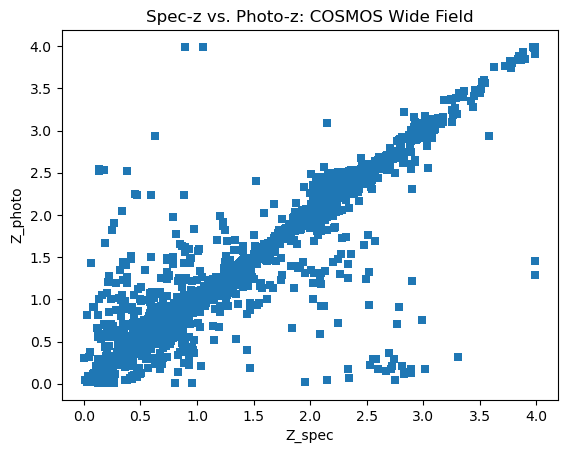

In [52]:
plt.scatter(wide["Z"], wide["Z_COSMOS_MEAN"], lw=0.0, marker=",")
pl.xlabel("Z_spec")
pl.ylabel("Z_photo")
plt.title("Spec-z vs. Photo-z: COSMOS Wide Field")

## 2.) Distribution of i-band Magnitude
- shows how many galaxies fall into each magnitude range for the i-band.
- lower magnitudes correlate to brighter galaxies.
- photo-z accuracy degrades for fainter galaxies (fewer + noisier)

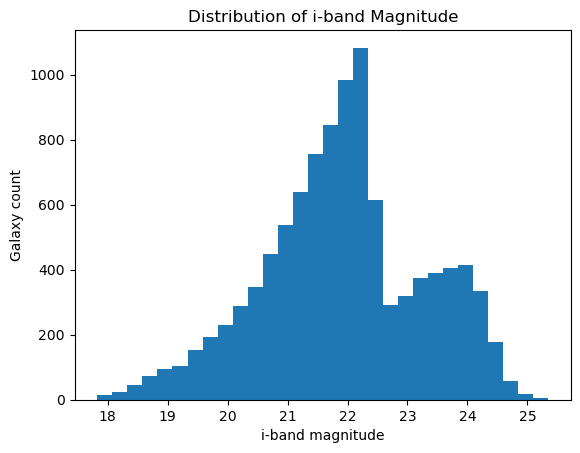

In [23]:
plt.hist(wide['BDF_MAG_DERED_CALIB_I'].dropna(), bins=30)

plt.xlabel('i-band magnitude')
plt.ylabel('Galaxy count')
plt.title('Distribution of i-band Magnitude')
plt.show()

## 3.) Sky Positions of COSMOS Galaxies (RA vs. DEC)
- RA: right ascension (sky longitude)
- DEC: declination (sky latitude)
- Shows the sky positions of the galaxies collected by the COSMOS wide field (spatial coverage)

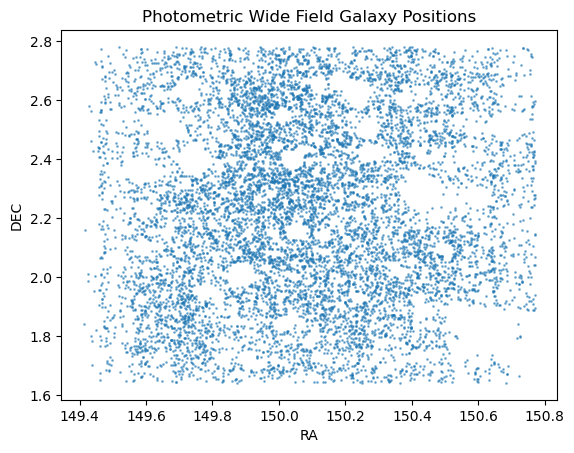

In [40]:
plt.scatter(wide['RA'], wide['DEC'], s=1, alpha=0.5)

plt.xlabel('RA')
plt.ylabel('DEC')
plt.title('Photometric Wide Field Galaxy Positions')
plt.show()

## 4.) i) Binned Statistics of Δz by Redshift and Magnitude

### Count: how many galaxies fall into each i-band mag bin, and redshift bin
- shows how many galaxies span a region of space in our data.
- If a bin has low count, then med and std in that bin may not be reliable.

### Median: shows bias in data
- photo-z bias. The median difference between photoz and specz for each bin.
- If values are positive, COSMOS overestimates redshift, if negative then it's an underestimate.
- Tells us which regions of COSMOS Photoz are trustworthy vs. more skewed.

### std: shows data's scatter
- Shows spread of dz values (how inconsistent photoz estimates are in a bin.
- High scatter= high uncertainty --> not great.
- Bins with high std shows photo-z are unreliable or inconsistent even if not biased.
- Helps underline confidence in redshift data from photo-z.

In [41]:
#define DES bin edges
z_bins = np.array([0.0, 0.3, 0.7, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0])
mag_bins = np.array([15.5, 22.0, 23.0, 24.0, 29.0])

#filter for valid rows and remove outliers (nans)
valid = wide[['Z_COSMOS_MEAN', 'Z', 'BDF_MAG_DERED_CALIB_I']].dropna().copy()

#apply DES outlier condit: exclude galaxies with |Δz / z_spec| > 0.15
mask = (np.abs(valid['Z_COSMOS_MEAN'] - valid['Z']) / valid['Z']) <= 0.15
valid = valid[mask]

#calculate dz
valid['dz'] = valid['Z_COSMOS_MEAN'] - valid['Z']

In [42]:
#assign redshift and i-band magnitude bins
valid['z_bin'] = pd.cut(valid['Z'], bins=z_bins)
valid['mag_bin'] = pd.cut(valid['BDF_MAG_DERED_CALIB_I'], bins=mag_bins)

In [43]:
#group and compute count, median, std
grouped = valid.groupby(['mag_bin', 'z_bin'], observed=True)
stats = grouped['dz'].agg(['count', 'median', 'std']).unstack(level=1)

#format heatmap 
stats.index = stats.index.astype(str)
stats.columns = stats.columns.set_levels([str(c) for c in stats.columns.levels[1]], level=1)

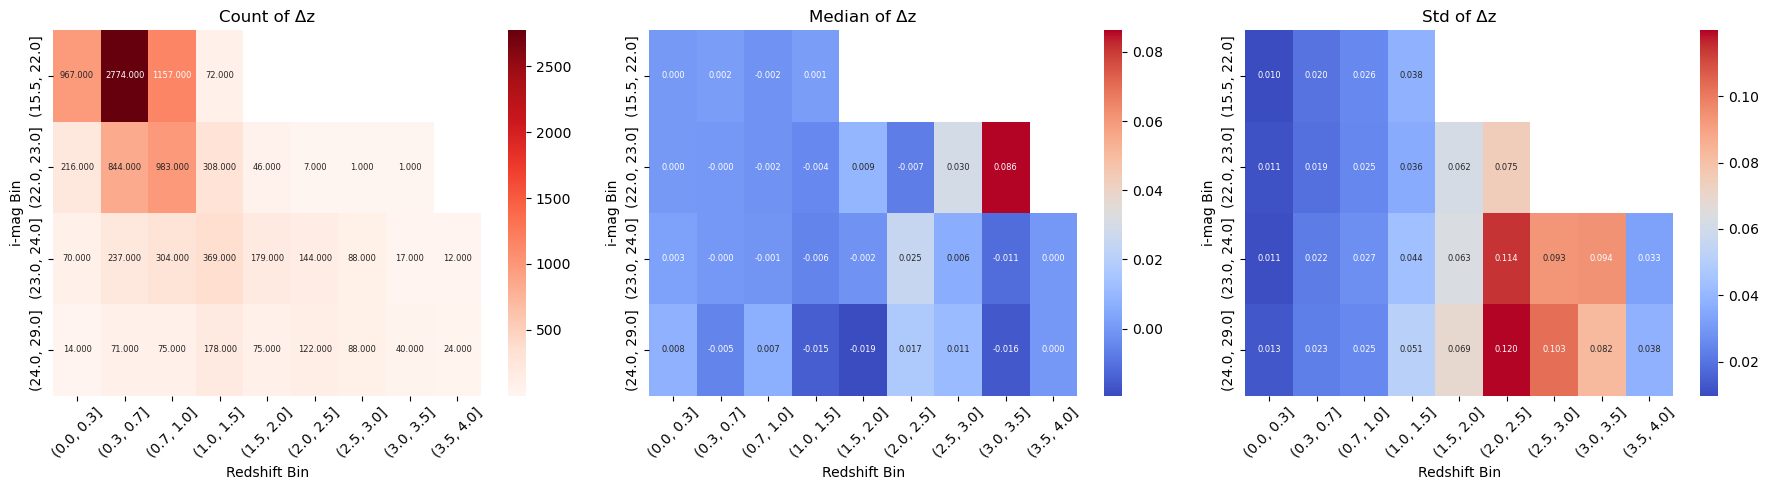

In [44]:
#plot the heatmaps
plt.figure(figsize=(18, 5))
for i, metric in enumerate(["count", "median", "std"]):
    plt.subplot(1, 3, i + 1)
    cmap = "Reds" if metric == "count" else "coolwarm"
    sns.heatmap(stats[metric], annot=True, fmt=".3f", cmap=cmap,
                annot_kws={"size": 6}, cbar=True)
    plt.title(f"{metric.title()} of Δz")
    plt.xlabel("Redshift Bin")
    plt.ylabel("i-mag Bin")
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [45]:
stats

count                                              \
z_bin        (0.0, 0.3] (0.3, 0.7] (0.7, 1.0] (1.0, 1.5] (1.5, 2.0]   
mag_bin                                                               
(15.5, 22.0]      967.0     2774.0     1157.0       72.0        NaN   
(22.0, 23.0]      216.0      844.0      983.0      308.0       46.0   
(23.0, 24.0]       70.0      237.0      304.0      369.0      179.0   
(24.0, 29.0]       14.0       71.0       75.0      178.0       75.0   

                                                             median  ...  \
z_bin        (2.0, 2.5] (2.5, 3.0] (3.0, 3.5] (3.5, 4.0] (0.0, 0.3]  ...   
mag_bin                                                              ...   
(15.5, 22.0]        NaN        NaN        NaN        NaN   0.000094  ...   
(22.0, 23.0]        7.0        1.0        1.0        NaN   0.000330  ...   
(23.0, 24.0]      144.0       88.0       17.0       12.0   0.002704  ...   
(24.0, 29.0]      122.0       88.0       40.0       24.0   0.007791  ...   

                               std                                   \
z_bin        (3.5, 4.0] (0.0, 0.3] (0.3, 0.7] (0.7, 1.0] (1.0, 1.5]   
mag_bin                                                               
(15.5, 22.0]        NaN   0.009787   0.019697   0.025601   0.038033   
(22.0, 23.0]        NaN   0.011300   0.019229   0.025140   0.035785   
(23.0, 24.0]        0.0   0.010557   0.021922   0.027092   0.043615   
(24.0, 29.0]        0.0   0.012568   0.022834   0.025433   0.051378   

                                                                     
z_bin        (1.5, 2.0] (2.0, 2.5] (2.5, 3.0] (3.0, 3.5] (3.5, 4.0]  
mag_bin                                                              
(15.5, 22.0]        NaN        NaN        NaN        NaN        NaN  
(22.0, 23.0]   0.061553   0.074596        NaN        NaN        NaN  
(23.0, 24.0]   0.063084   0.114422   0.093315   0.094158   0.032827  
(24.0, 29.0]   0.069086   0.119821   0.102831   0.082414   0.038443  

[4 rows x 27 columns]

## 4.) ii) Spectra vs. Photometric Redshift by Magnitude Bin
- likey nature of the data sample, but higher magntiudes (fainter galaxies) exhibiting better overlap

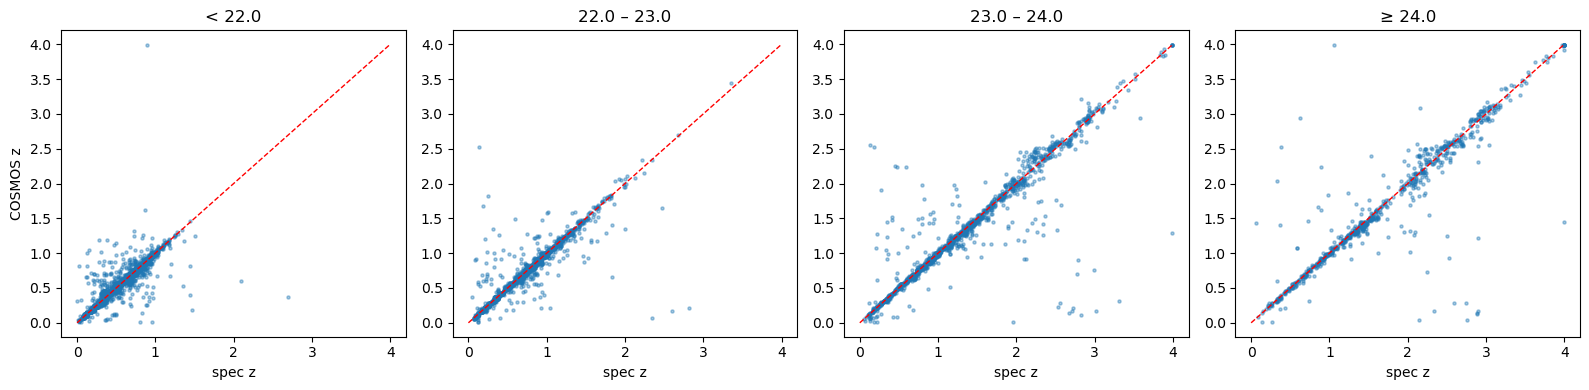

In [64]:
mag_labels = ["< 22.0", "22.0 – 23.0", "23.0 – 24.0", "≥ 24.0"]
mag_cuts = [(15.5, 22.0), (22.0, 23.0), (23.0, 24.0), (24.0, 29.0)]

plt.figure(figsize=(16, 4))

for i, (low, high) in enumerate(mag_cuts):
    subset = wide[(wide["BDF_MAG_DERED_CALIB_I"] >= low) & (wide["BDF_MAG_DERED_CALIB_I"] < high)]
    subset = subset.dropna(subset=["Z", "Z_COSMOS_MEAN"])
    plt.subplot(1, 4, i+1)
    plt.scatter(subset["Z"], subset["Z_COSMOS_MEAN"], s=5, alpha=0.4)
    plt.plot([0, 4], [0, 4], 'r--', lw=1)
    plt.title(f"{mag_labels[i]}")
    plt.xlabel("spec z")
    if i == 0:
        plt.ylabel("COSMOS z")
        
plt.tight_layout()
plt.show()

# Graphs exploring the COSMOS Deep Field Survey data

### Deep Field Data Loading and Inspection

In [28]:
deep.head(10)     #first 10 rows
deep.tail(5)      #last 5 rows

#deep.columns.tolist()

#have calibrated magnitudes U,G,R,I,Z,J,H,K
#color is differences between bands, so U-G, G-R, R-I, I-Z, Z-J, J-H, H-K



,BDF_FLUX_DERED_CALIB_U,BDF_FLUX_DERED_CALIB_G,BDF_FLUX_DERED_CALIB_R,BDF_FLUX_DERED_CALIB_I,BDF_FLUX_DERED_CALIB_Z,BDF_FLUX_DERED_CALIB_J,BDF_FLUX_DERED_CALIB_H,BDF_FLUX_DERED_CALIB_K,BDF_FLUX_ERR_DERED_CALIB_U,BDF_FLUX_ERR_DERED_CALIB_G,...,Z3_90,Z3_91,Z3_92,Z3_93,Z3_94,Z3_95,Z3_96,Z3_97,Z3_98,Z3_99
4907202,17.716839,34.042599,82.927162,204.356644,441.046722,880.753357,1564.286621,2504.600098,8.133388,4.875057,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4907203,47.160877,99.759995,476.465576,1416.068237,2919.698486,4709.708496,6859.435547,9347.838867,7.418569,4.285843,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4907227,707.835571,924.834900,2293.729004,2866.188477,3404.617920,4157.775879,4685.667480,5385.307617,11.558760,7.212730,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4908177,465.838928,672.987610,1525.025024,1880.364746,2455.655518,2698.938232,3559.527344,4257.510254,7.531440,4.570012,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4908212,413.786377,403.116333,836.500427,1418.635742,2456.429688,4010.084473,6001.782715,9378.264648,11.063272,6.748053,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Checking color data

In [65]:
deep["U-G"] = deep["BDF_MAG_DERED_CALIB_U"] - deep["BDF_MAG_DERED_CALIB_G"]
deep["G-R"] = deep["BDF_MAG_DERED_CALIB_G"] - deep["BDF_MAG_DERED_CALIB_R"]
deep["R-I"] = deep["BDF_MAG_DERED_CALIB_R"] - deep["BDF_MAG_DERED_CALIB_I"]
deep["I-Z"] = deep["BDF_MAG_DERED_CALIB_I"] - deep["BDF_MAG_DERED_CALIB_Z"]

#deep[["U-G", "G-R", "R-I", "I-Z"]].describe()
#check that numbers are reasonable --> is filtering working well

for band in ["U", "G", "R", "I", "Z"]:
    col = f"BDF_MAG_DERED_CALIB_{band}"
    deep = deep[np.isfinite(deep[col])]
    deep = deep[deep[col] < 35]  # filters unreasonably faint (or placeholder) mags


In [66]:
deep[["U-G", "G-R", "R-I", "I-Z"]].describe()

,U-G,G-R,R-I,I-Z
count,10183.000000,10183.000000,10183.000000,10183.000000
mean,0.546686,0.840217,0.467986,0.261193
std,0.558817,0.493619,0.303851,0.196500
min,-2.345329,-0.277176,-0.677450,-1.106016
25%,0.154989,0.491201,0.234119,0.139043
50%,0.424477,0.761967,0.427359,0.248959
75%,0.752853,1.072017,0.649868,0.363998
max,7.014372,3.630423,1.610691,1.251364


## 5.) Heatmaps of Δz for Bluer and Redder Galaxies

In [68]:
#define bin edges (same as b4)
z_bins = np.array([0.0, 0.3, 0.7, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0])
mag_bins = np.array([15.5, 22.0, 23.0, 24.0, 29.0])

In [69]:
#filter and clean data (not my reasoning, I stole this from the articles+ copilot
cols_needed = ['Z_COSMOS_MEAN', 'Z', 'BDF_MAG_DERED_CALIB_I',
               'BDF_MAG_DERED_CALIB_G', 'BDF_MAG_DERED_CALIB_R']
deep_valid = deep[cols_needed].dropna().copy()
mask = (np.abs(deep_valid['Z_COSMOS_MEAN'] - deep_valid['Z']) / deep_valid['Z']) <= 0.15
deep_valid = deep_valid[mask]

In [70]:
#compute colors and dz
deep_valid['G-R'] = deep_valid['BDF_MAG_DERED_CALIB_G'] - deep_valid['BDF_MAG_DERED_CALIB_R']
deep_valid['R-I'] = deep_valid['BDF_MAG_DERED_CALIB_R'] - deep_valid['BDF_MAG_DERED_CALIB_I']
deep_valid['dz'] = deep_valid['Z_COSMOS_MEAN'] - deep_valid['Z']

In [71]:
#assign redshift and i-mag bins
deep_valid['z_bin'] = pd.cut(deep_valid['Z'], bins=z_bins)
deep_valid['mag_bin'] = pd.cut(deep_valid['BDF_MAG_DERED_CALIB_I'], bins=mag_bins)

In [72]:
#create bluer and redder subsets, for optical red and blue (r-i for red, g-r for blue)
bluer = deep_valid[deep_valid['G-R'] < 0.8]
redder = deep_valid[deep_valid['R-I'] >= 0.5]

In [73]:
#define plotting function
def plot_heatmaps(df, title_suffix):
    grouped = df.groupby(['mag_bin', 'z_bin'], observed=True)
    stats = grouped['dz'].agg(['count', 'median', 'std']).unstack(level=1)
    stats.index = stats.index.astype(str)
    stats.columns = stats.columns.set_levels([str(c) for c in stats.columns.levels[1]], level=1)

    plt.figure(figsize=(18, 5))
    for i, metric in enumerate(['count', 'median', 'std']):
        plt.subplot(1, 3, i + 1)
        cmap = 'Reds' if metric == 'count' else 'coolwarm'
        sns.heatmap(stats[metric], annot=True, fmt=".3f", cmap=cmap,
                    annot_kws={"size": 6}, cbar=True)
        plt.title(f"{metric.title()} of Δz ({title_suffix})")
        plt.xlabel("Redshift Bin")
        plt.ylabel("i-mag Bin")
        plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

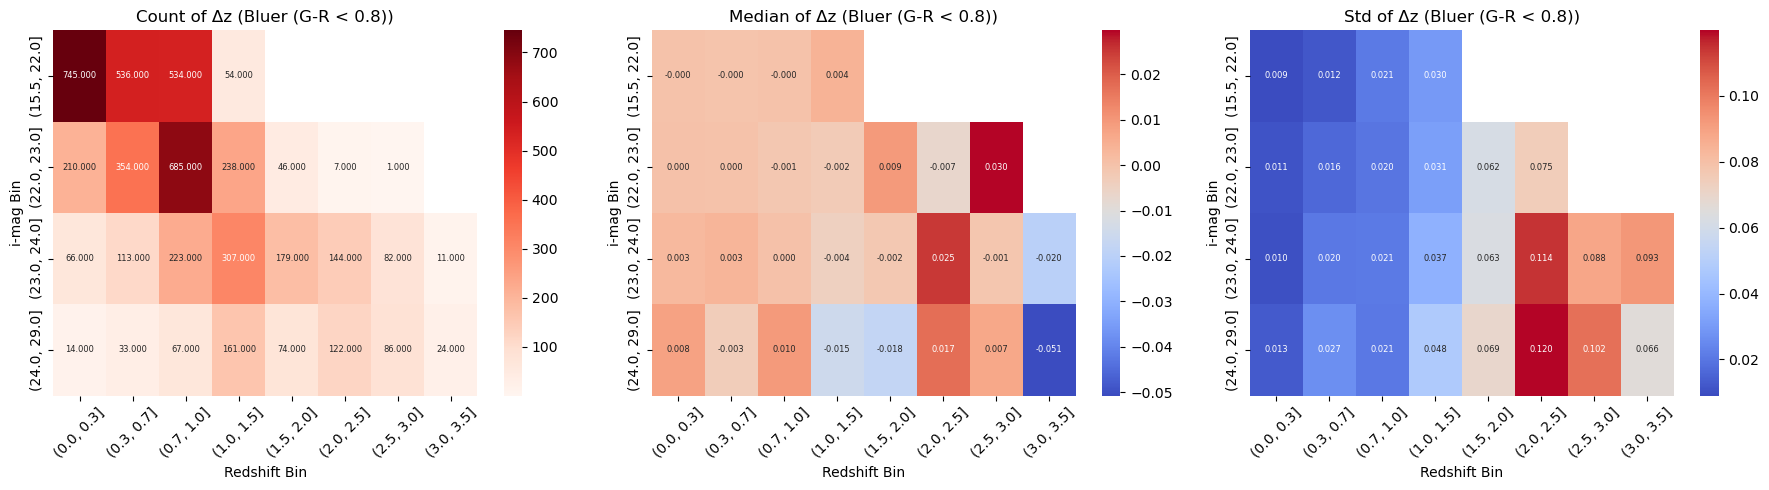

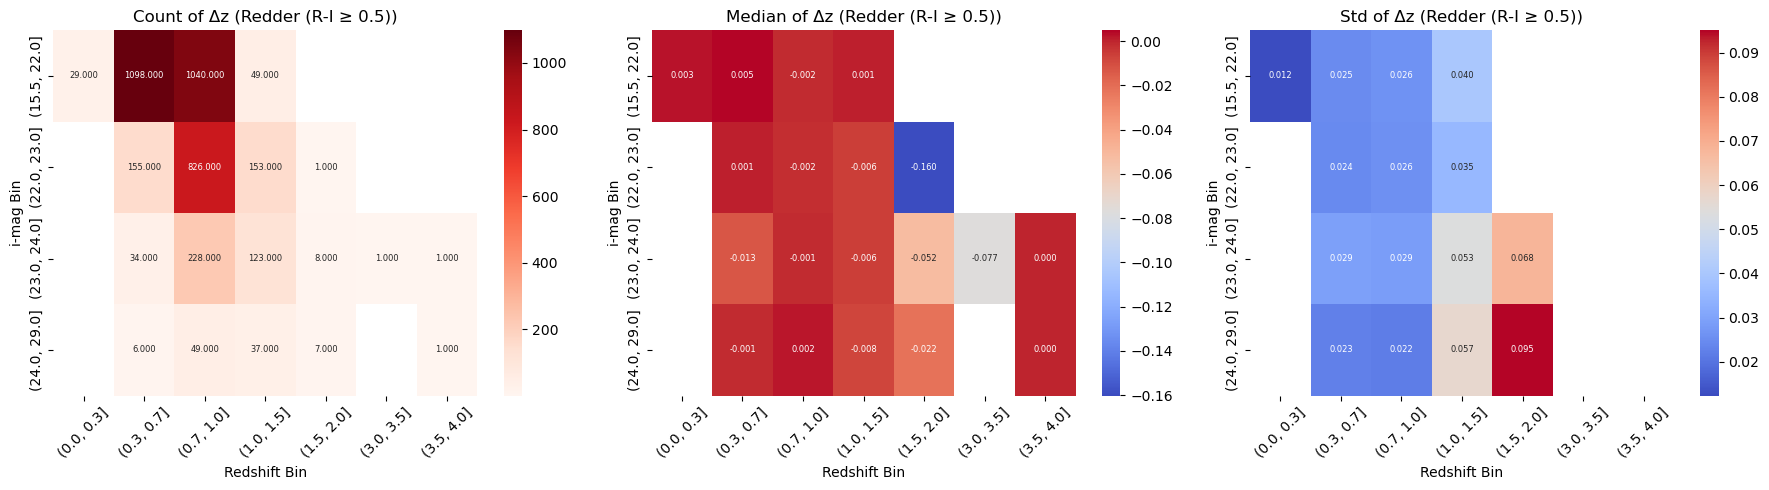

count                                              \
z_bin        (0.0, 0.3] (0.3, 0.7] (0.7, 1.0] (1.0, 1.5] (1.5, 2.0]   
mag_bin                                                               
(15.5, 22.0]      967.0     2774.0     1157.0       72.0        NaN   
(22.0, 23.0]      216.0      844.0      983.0      308.0       46.0   
(23.0, 24.0]       70.0      237.0      304.0      369.0      179.0   
(24.0, 29.0]       14.0       71.0       75.0      178.0       75.0   

                                                             median  ...  \
z_bin        (2.0, 2.5] (2.5, 3.0] (3.0, 3.5] (3.5, 4.0] (0.0, 0.3]  ...   
mag_bin                                                              ...   
(15.5, 22.0]        NaN        NaN        NaN        NaN   0.000094  ...   
(22.0, 23.0]        7.0        1.0        1.0        NaN   0.000330  ...   
(23.0, 24.0]      144.0       88.0       17.0       12.0   0.002704  ...   
(24.0, 29.0]      122.0       88.0       40.0       24.0   0.007791  ...   

                               std                                   \
z_bin        (3.5, 4.0] (0.0, 0.3] (0.3, 0.7] (0.7, 1.0] (1.0, 1.5]   
mag_bin                                                               
(15.5, 22.0]        NaN   0.009787   0.019697   0.025601   0.038033   
(22.0, 23.0]        NaN   0.011300   0.019229   0.025140   0.035785   
(23.0, 24.0]        0.0   0.010557   0.021922   0.027092   0.043615   
(24.0, 29.0]        0.0   0.012568   0.022834   0.025433   0.051378   

                                                                     
z_bin        (1.5, 2.0] (2.0, 2.5] (2.5, 3.0] (3.0, 3.5] (3.5, 4.0]  
mag_bin                                                              
(15.5, 22.0]        NaN        NaN        NaN        NaN        NaN  
(22.0, 23.0]   0.061553   0.074596        NaN        NaN        NaN  
(23.0, 24.0]   0.063084   0.114422   0.093315   0.094158   0.032827  
(24.0, 29.0]   0.069086   0.119821   0.102831   0.082414   0.038443  

[4 rows x 27 columns]

In [74]:
#plot both sets
plot_heatmaps(bluer, "Bluer (G-R < 0.8)")
plot_heatmaps(redder, "Redder (R-I ≥ 0.5)")

stats

## 6.) Color Distribution: G-R and R-I

Text(0.5, 1.0, 'R-I Color Distribution')

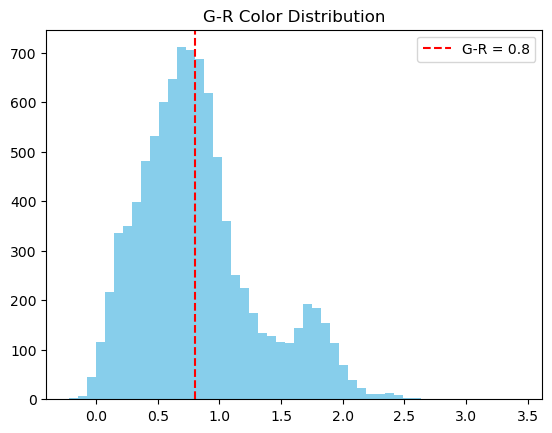

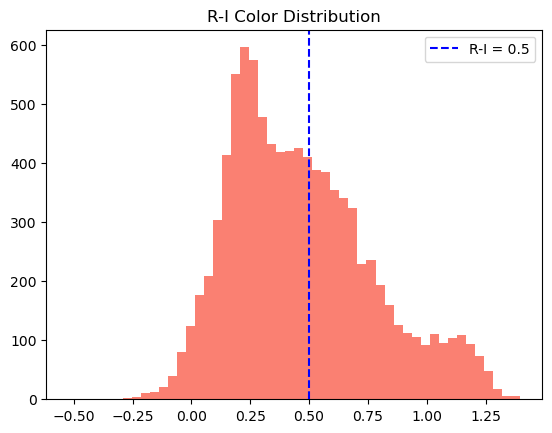

In [75]:
plt.hist(deep_valid['G-R'], bins=50, color='skyblue')
plt.axvline(0.8, color='red', linestyle='--', label='G-R = 0.8')
plt.legend()
plt.title("G-R Color Distribution")

plt.figure()
plt.hist(deep_valid['R-I'], bins=50, color='salmon')
plt.axvline(0.5, color='blue', linestyle='--', label='R-I = 0.5')
plt.legend()
plt.title("R-I Color Distribution")

# Deep Field vs. Wide Field graphs

## 7.) (Spec-Z) Redshift distribution Distribution of COSMOS-Deep vs. COSMOS-Wide

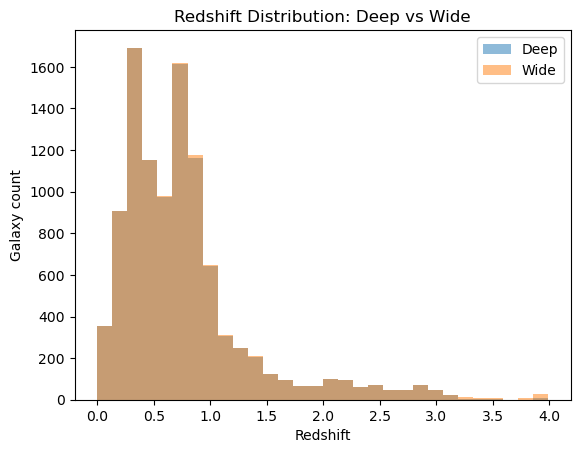

In [33]:
plt.hist(deep['Z'], bins=30, alpha=0.5, label='Deep')
plt.hist(wide['Z'], bins=30, alpha=0.5, label='Wide')
plt.xlabel('Redshift')
plt.ylabel('Galaxy count')
plt.legend()
plt.title('Redshift Distribution: Deep vs Wide')
plt.show()